In [2]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [4]:
#import data
data = pd.read_csv('cbb25.csv')

In [6]:
#check for missing values 
missing_vals = data.isnull().sum()
print('sum of missing values per column:')
print(missing_vals)

#convert year from text to data format
if 'YEAR' in data.columns:
    df['DATE'] = pd.to_datetime(df['YEAR'], format='%Y')

data.info()

sum of missing values per column:
RK           0
Team         0
CONF         0
G            0
W            0
ADJOE        0
ADJDE        0
BARTHAG      0
EFG_O        0
EFG_D        0
TOR          0
TORD         0
ORB          0
DRB          0
FTR          0
FTRD         0
2P_O         0
2P_D         0
3P_O         0
3P_D         0
3PR          0
3PRD         0
ADJ_T        0
WAB          0
SEED       296
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RK       364 non-null    int64  
 1   Team     364 non-null    object 
 2   CONF     364 non-null    object 
 3   G        364 non-null    int64  
 4   W        364 non-null    int64  
 5   ADJOE    364 non-null    float64
 6   ADJDE    364 non-null    float64
 7   BARTHAG  364 non-null    float64
 8   EFG_O    364 non-null    float64
 9   EFG_D    364 non-null    float64
 10  TOR      364

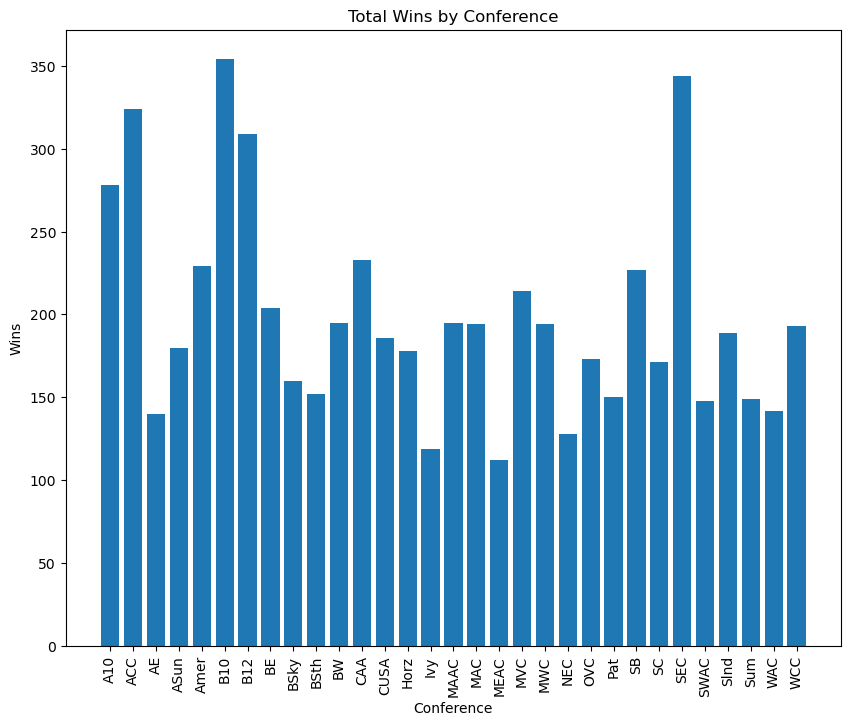

In [8]:
#visulizations and summary statistics
wins_by_conf = data.groupby('CONF')['W'].sum()

# Visualize the distribution of wins (W) by conference (CONF) using a histogram
plt.figure(figsize=(10, 8))
plt.bar(wins_by_conf.index, wins_by_conf.values)
plt.title('Total Wins by Conference')
plt.xlabel('Conference')
plt.ylabel('Wins')
plt.xticks(rotation=90)
plt.show()

In [10]:
#summary statistics
print(data.describe())

               RK           G           W       ADJOE       ADJDE     BARTHAG  \
count  364.000000  364.000000  364.000000  364.000000  364.000000  364.000000   
mean   182.500000   32.447802   16.934066  106.433516  106.433242    0.488307   
std    105.221988    1.259682    5.872009    7.661871    6.620135    0.258259   
min      1.000000   27.000000    3.000000   82.900000   88.000000    0.008600   
25%     91.750000   32.000000   13.000000  100.875000  101.950000    0.274600   
50%    182.500000   33.000000   17.000000  106.000000  106.750000    0.448650   
75%    273.250000   33.000000   21.000000  111.275000  111.225000    0.693275   
max    364.000000   36.000000   31.000000  129.000000  125.200000    0.982300   

            EFG_O       EFG_D         TOR        TORD  ...        FTRD  \
count  364.000000  364.000000  364.000000  364.000000  ...  364.000000   
mean    50.791484   50.911264   17.293956   17.254121  ...   33.234615   
std      3.015819    2.663695    1.964735    2.2

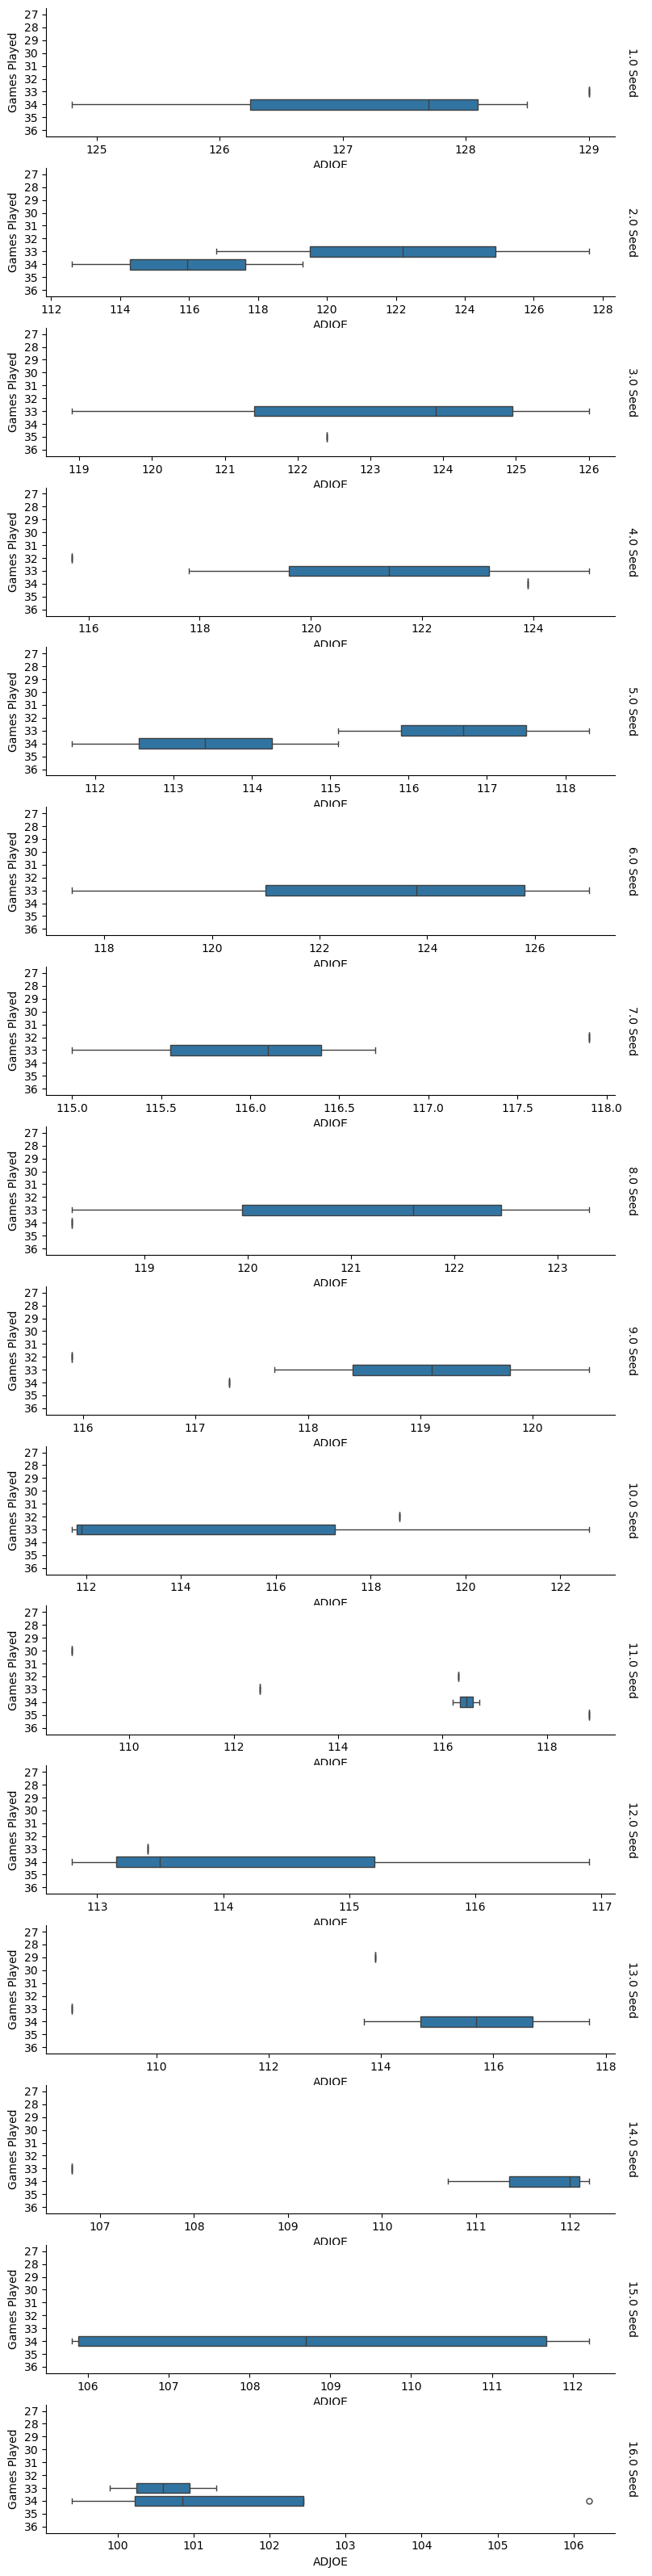

In [12]:
#Visualize relationship between Seed (1st-16th) and ADJOE: Adjusted Offensive Efficiency 
g = sns.catplot(
    data=data,
    x="ADJOE", y="G", row="SEED",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=2, aspect=4,
)
g.set(xlabel="ADJOE", ylabel="Games Played")
g.set_titles(row_template="{row_name} Seed")

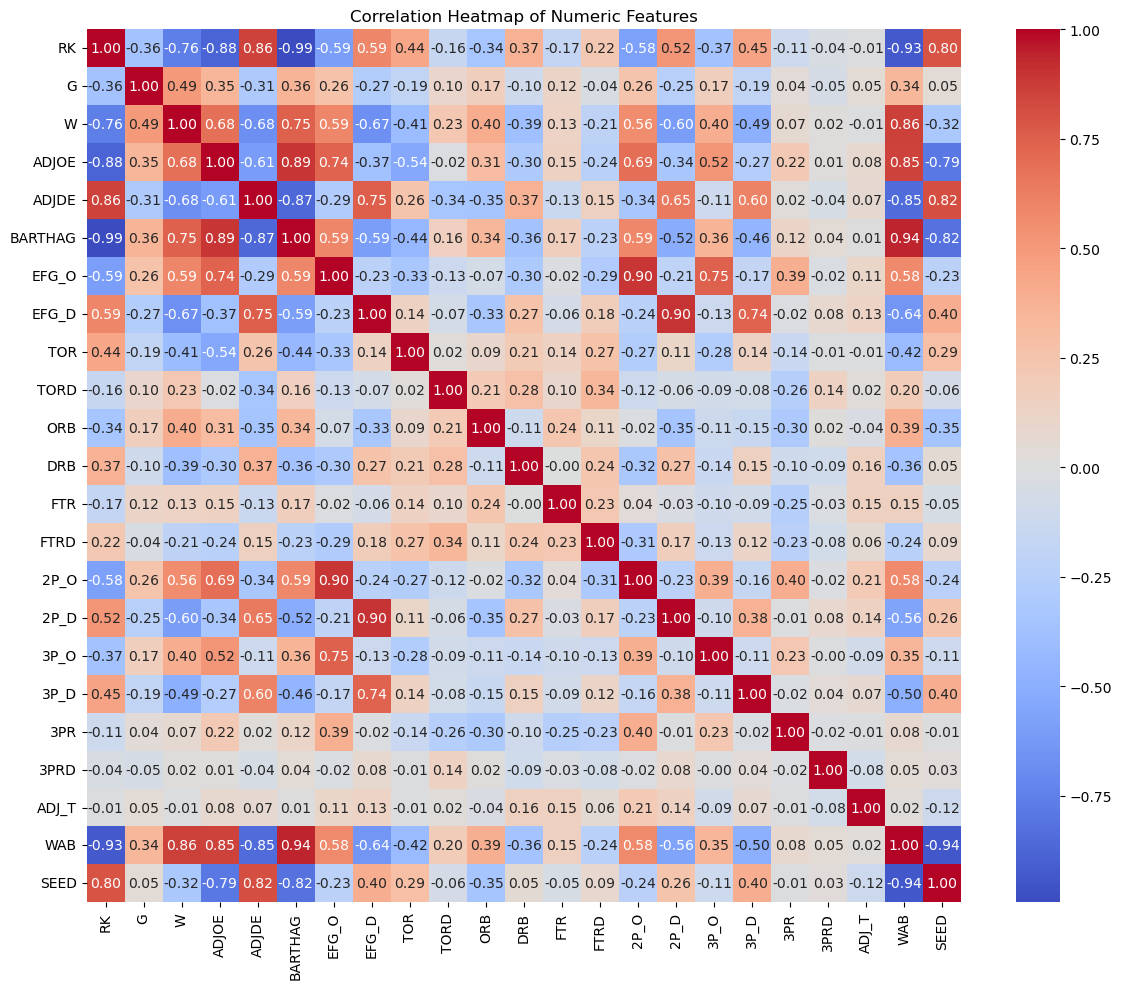

In [14]:
#correlation map for feature selection using only numeric variables
numeric_df = data.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    cor = numeric_df.corr()
    sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()

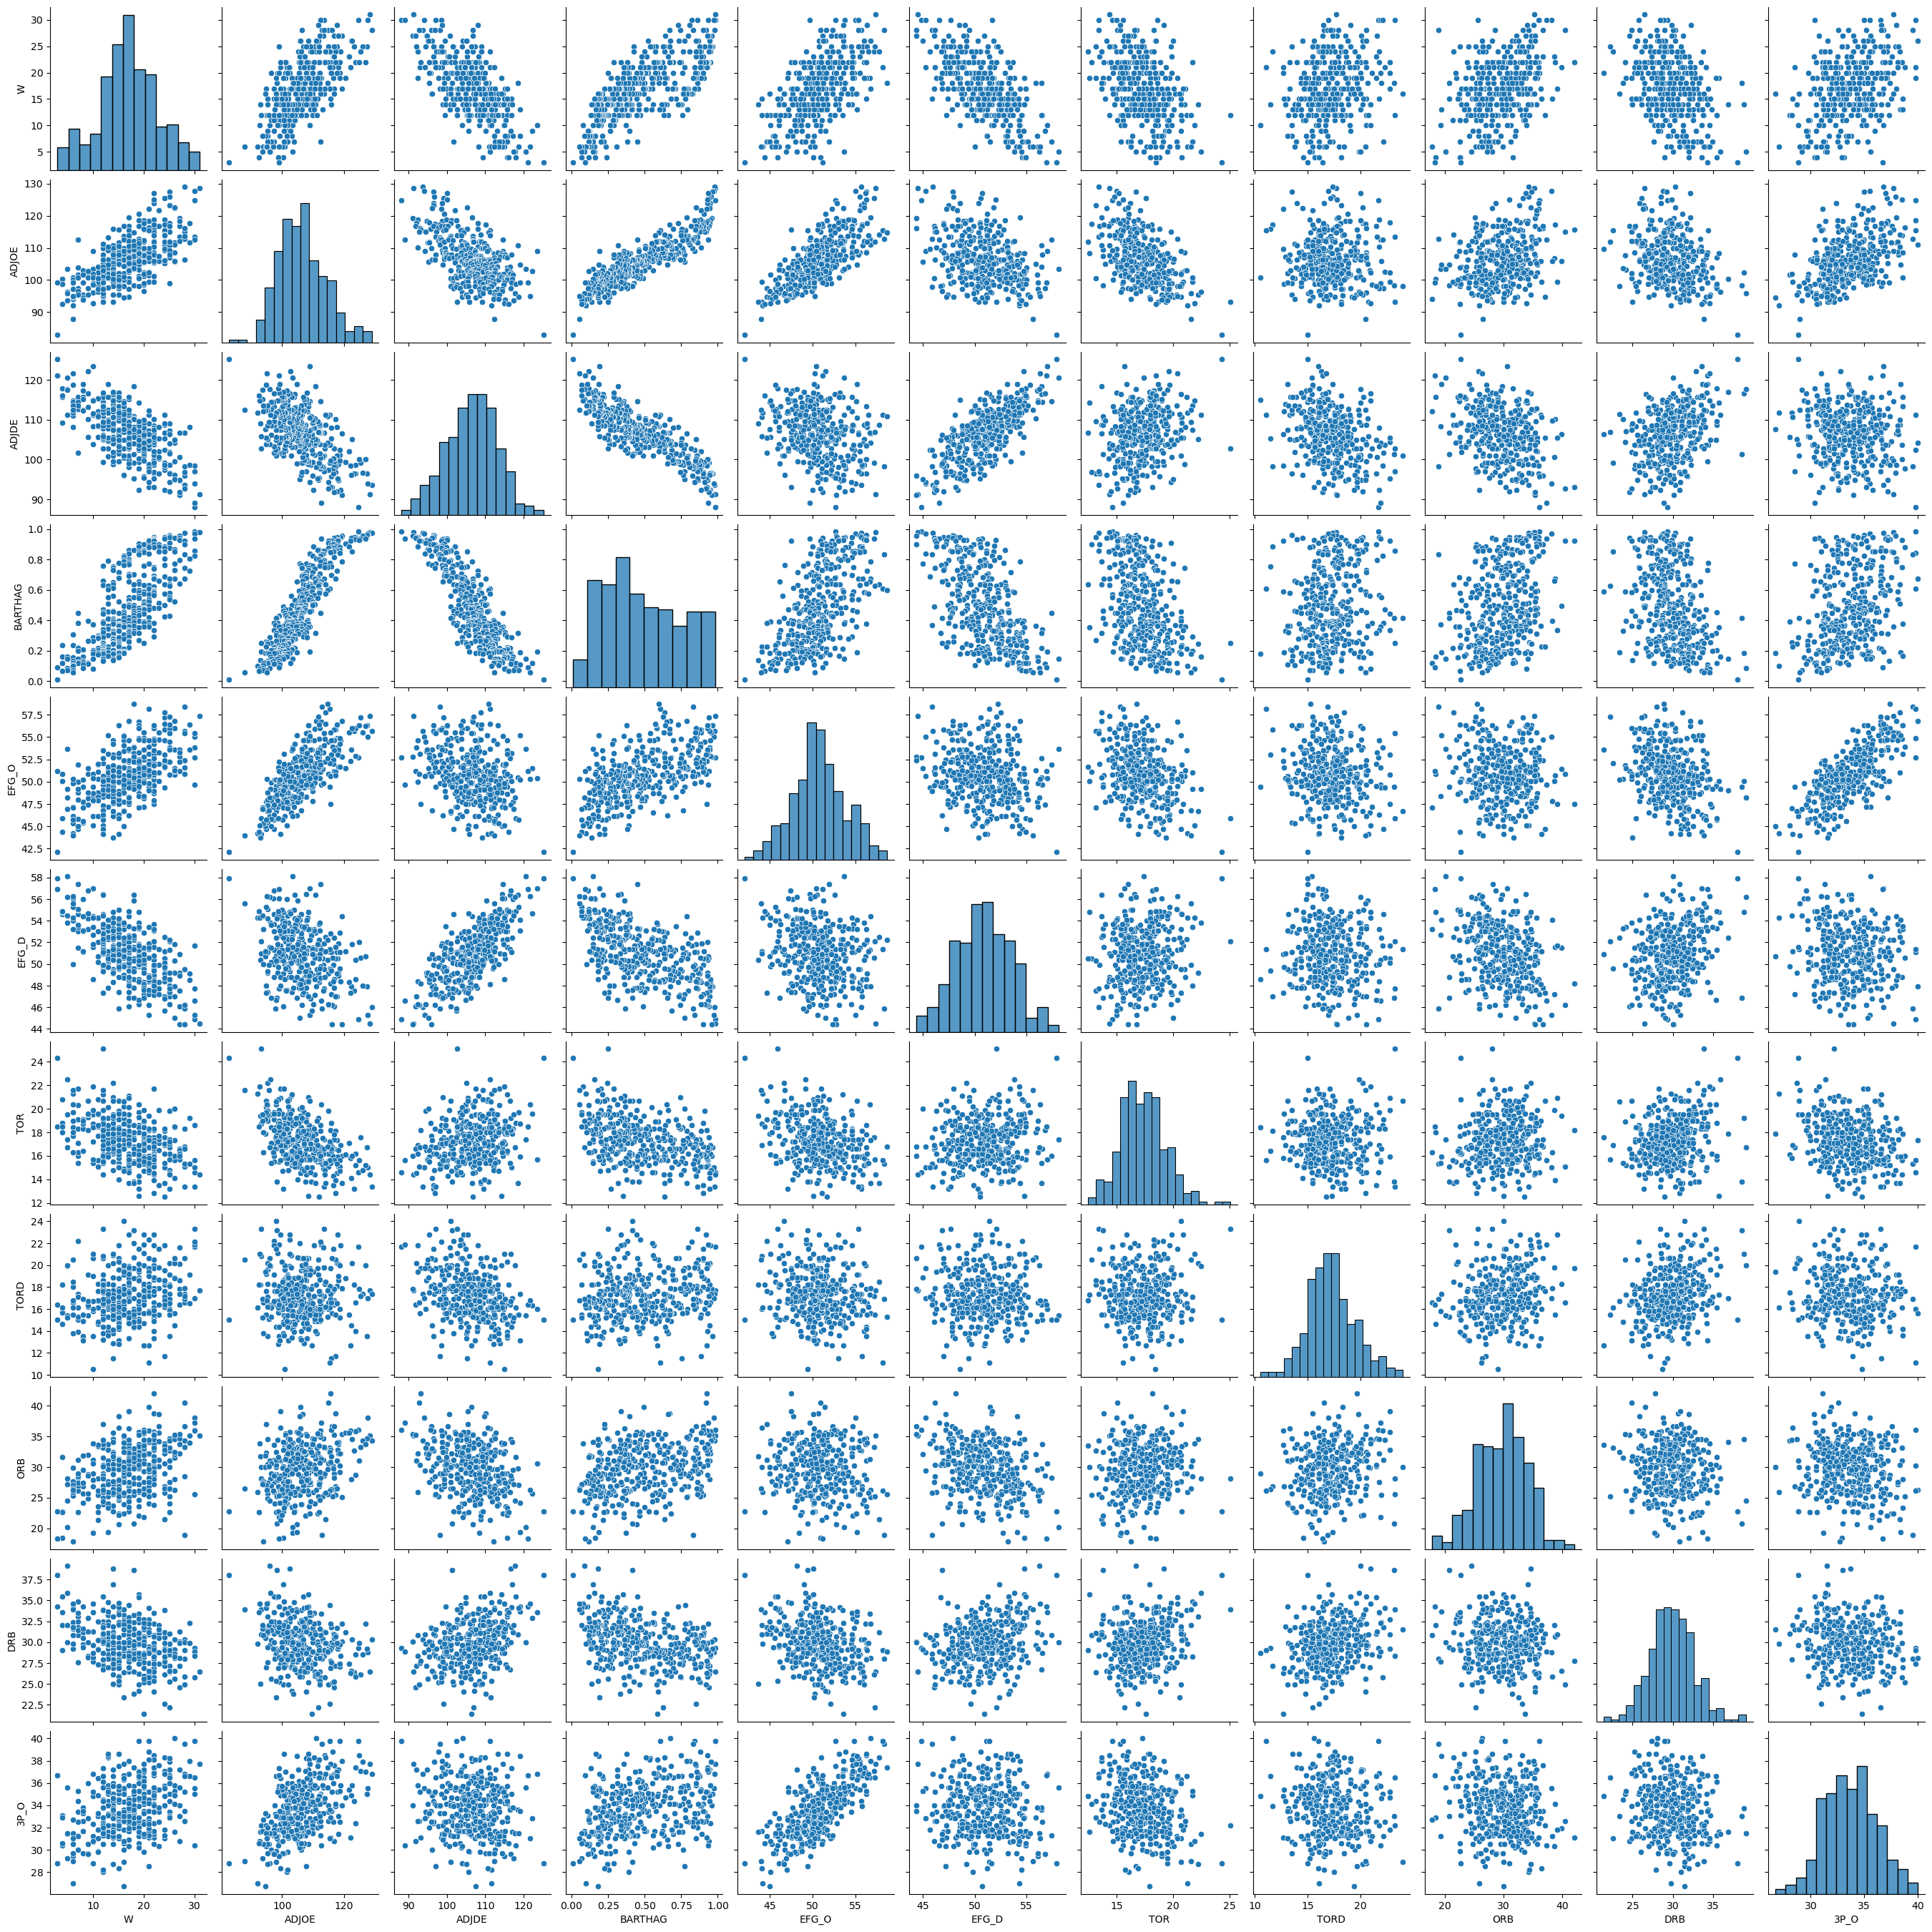

In [16]:
#feature selection 
features = ['W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 'DRB', '3P_O']

#plot features and remove NULL values
if all(col in data.columns for col in features):
    sns.pairplot(data[features].dropna())
    plt.show()

R2 Score of the model: -0.205


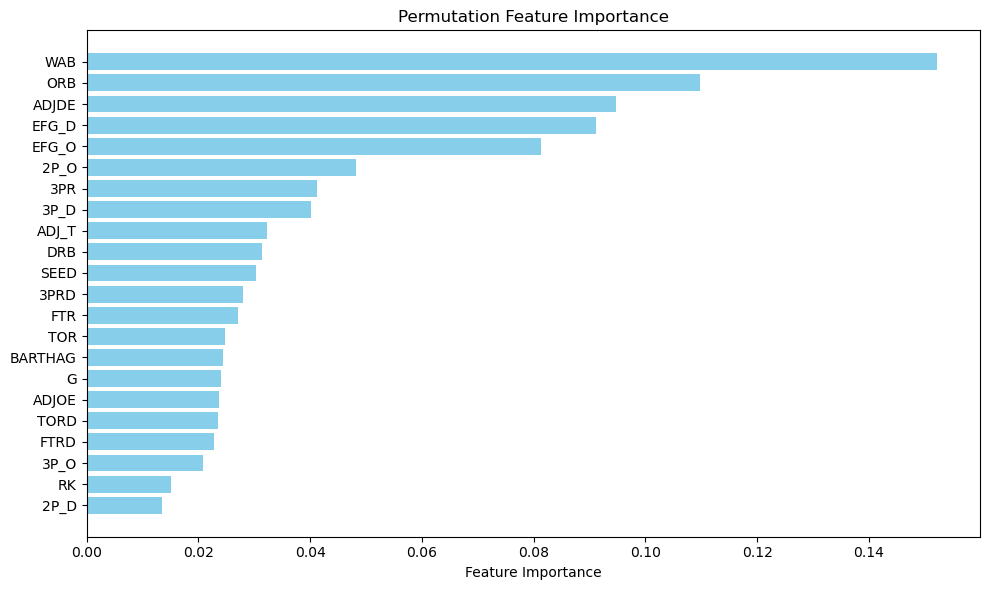

In [22]:
#predictive modeling -- target column is Wins (W)
cat_col = ['TEAM', 'CONF', 'POSTSEASON', 'DATE']
target_col = 'W'

# Filter features that are numeric and not in the exclusion list
features = [col for col in data.columns if col not in cat_col + [target_col] and pd.api.types.is_numeric_dtype(data[col])]

#drop NULL values
X = data[features].dropna()
y = data.loc[X.index, target_col]

#split dataset into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train random forrest model 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set and calculate the R-squared score
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R2 Score of the model: {score:.3f}")

# Permutation importance using feature importances from the Random Forest
important_features = rf.feature_importances_
indices = np.argsort(important_features)

plt.figure(figsize=(10, 6))
plt.barh(range(len(important_features)), important_features[indices], color='skyblue')
plt.yticks(range(len(important_features)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

R2 Score of the model: 0.826


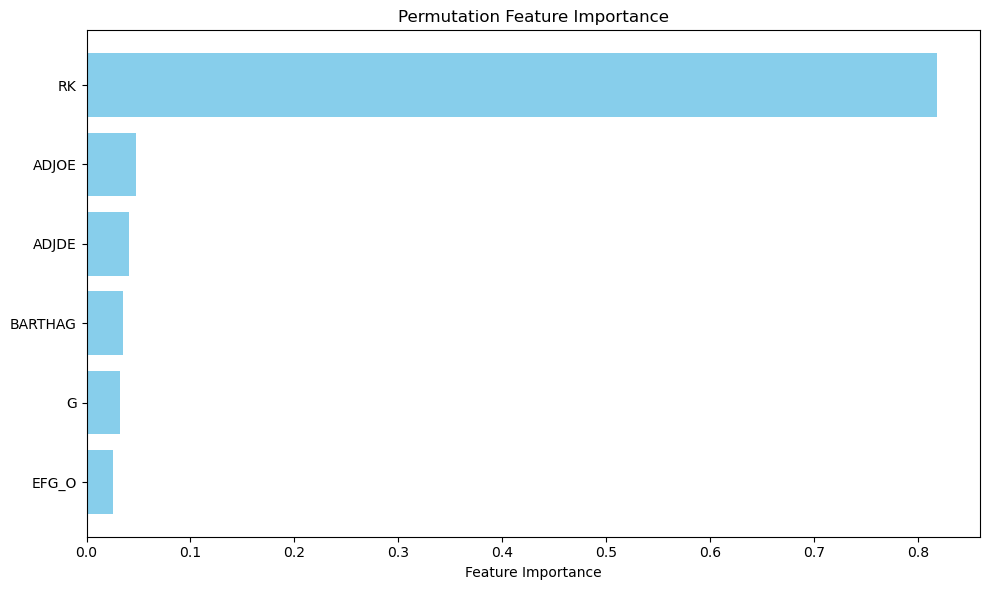

In [24]:
#remove less important features and re-fit model 
features_2 = ['WAB', 'ORB', 'ADJDE', 'EFG_D', 'EFG_O', '2P_O'] #features from previous model with high importance

X = data[features_2].dropna()
y = data.loc[X.index, target_col]

#split dataset into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train random forrest model 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set and calculate the R-squared score
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R2 Score of the model: {score:.3f}")

# Permutation importance using feature importances from the Random Forest
important_features = rf.feature_importances_
indices = np.argsort(important_features)

plt.figure(figsize=(10, 6))
plt.barh(range(len(important_features)), important_features[indices], color='skyblue')
plt.yticks(range(len(important_features)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()